# Three Approaches to Encoding Time Information as Features for ML Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from sklego.preprocessing import RepeatingBasisFunction

In [40]:
import lightgbm as lgb

## データ作成

<AxesSubplot:title={'center':'Generate time series'}>

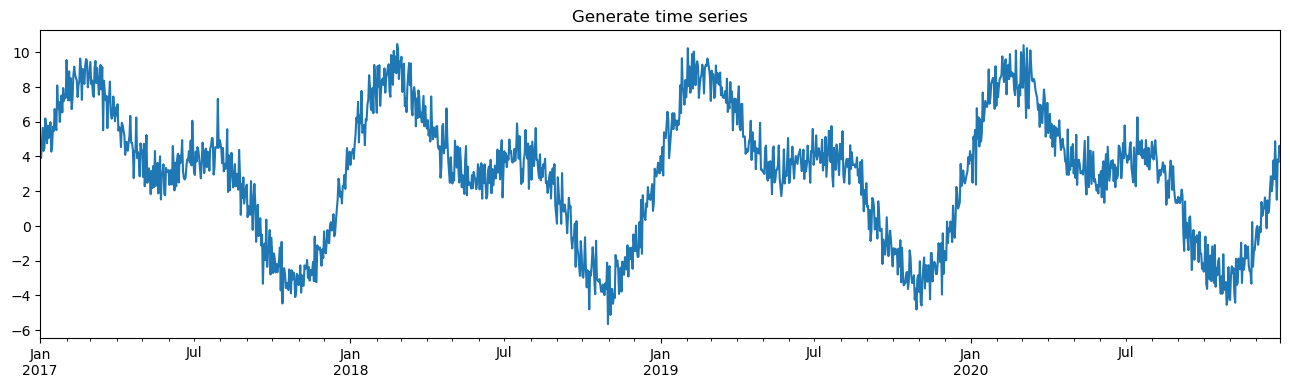

In [24]:
np.random.seed(42)

range_of_dates = pd.date_range(start='2017-01-01', end='2020-12-30')
X = pd.DataFrame(index=range_of_dates)

X['day_nr'] = range(len(X))
X['day_of_year'] = X.index.day_of_year

signal_1 = 3 + 4 * np.sin(X['day_nr'] / 365 * 2 * np.pi) # 一年で 2π
signal_2 = 3 * np.sin(X['day_nr'] / 365 * 4 * np.pi + 365/2) # 半年で 2π, 位相+365/2
noise = np.random.normal(0, 0.85, len(X)) # ノイズ

y = signal_1 + signal_2 + noise

y.plot(figsize=(16, 4), title='Generate time series')

In [31]:
results_df = y.to_frame()
results_df.head()

,day_nr
2017-01-01,4.273237
2017-01-02,3.900877
2017-01-03,4.735163
2017-01-04,5.644148
2017-01-05,4.314070


In [32]:
results_df.columns = ['actuals']

In [37]:
TRAIN_END = 3 * 365

## アプローチ1 : ダミー変数を使う

In [36]:
X_1 = pd.DataFrame(
    data=pd.get_dummies(X.index.month, drop_first=True, prefix='month')
)
X_1.index = X.index
X_1

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2017-01-01,0,0,0,0,0,0,0,0,0,0,0
2017-01-02,0,0,0,0,0,0,0,0,0,0,0
2017-01-03,0,0,0,0,0,0,0,0,0,0,0
2017-01-04,0,0,0,0,0,0,0,0,0,0,0
2017-01-05,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,0,0,0,0,0,0,0,0,0,0,1
2020-12-27,0,0,0,0,0,0,0,0,0,0,1
2020-12-28,0,0,0,0,0,0,0,0,0,0,1
2020-12-29,0,0,0,0,0,0,0,0,0,0,1


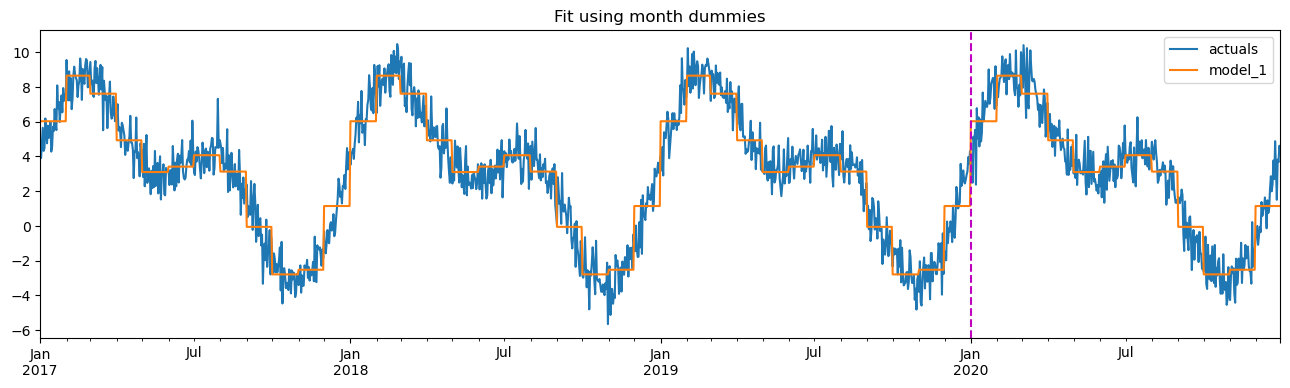

In [39]:
model_1 = LinearRegression().fit(X_1.iloc[:TRAIN_END], y.iloc[:TRAIN_END])

results_df['model_1'] = model_1.predict(X_1)
results_df[['actuals', 'model_1']].plot(figsize=(16, 4), title='Fit using month dummies')
plt.axvline(date(2020, 1, 1), c='m', linestyle='--')

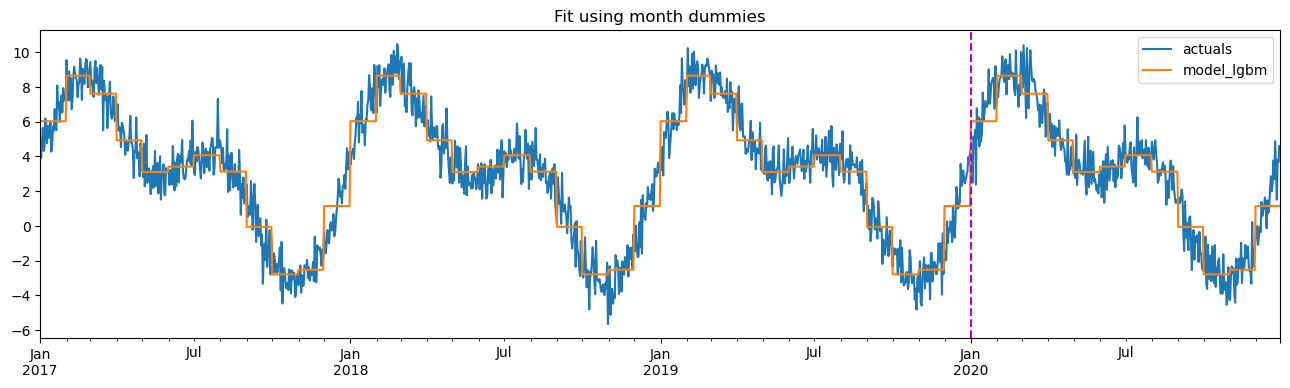

In [44]:
# if use ligntGBM
seed = 42
model_lgbm = lgb.LGBMRegressor(random_state=seed)

model_lgbm.fit(X_1.iloc[:TRAIN_END], y[:TRAIN_END])
results_df['model_lgbm'] = model_lgbm.predict(X_1)
results_df[['actuals', 'model_lgbm']].plot(figsize=(16, 4), title='Fit using month dummies(lightGBM)')

plt.axvline(date(2020, 1, 1), c='m', linestyle='--')

## アプローチ2 : サイン/コサイン変換を用いたサイクルエンコーディング

In [46]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

Text(0.5, 0.98, 'Cyclical encoding with sine/cosine transformation')

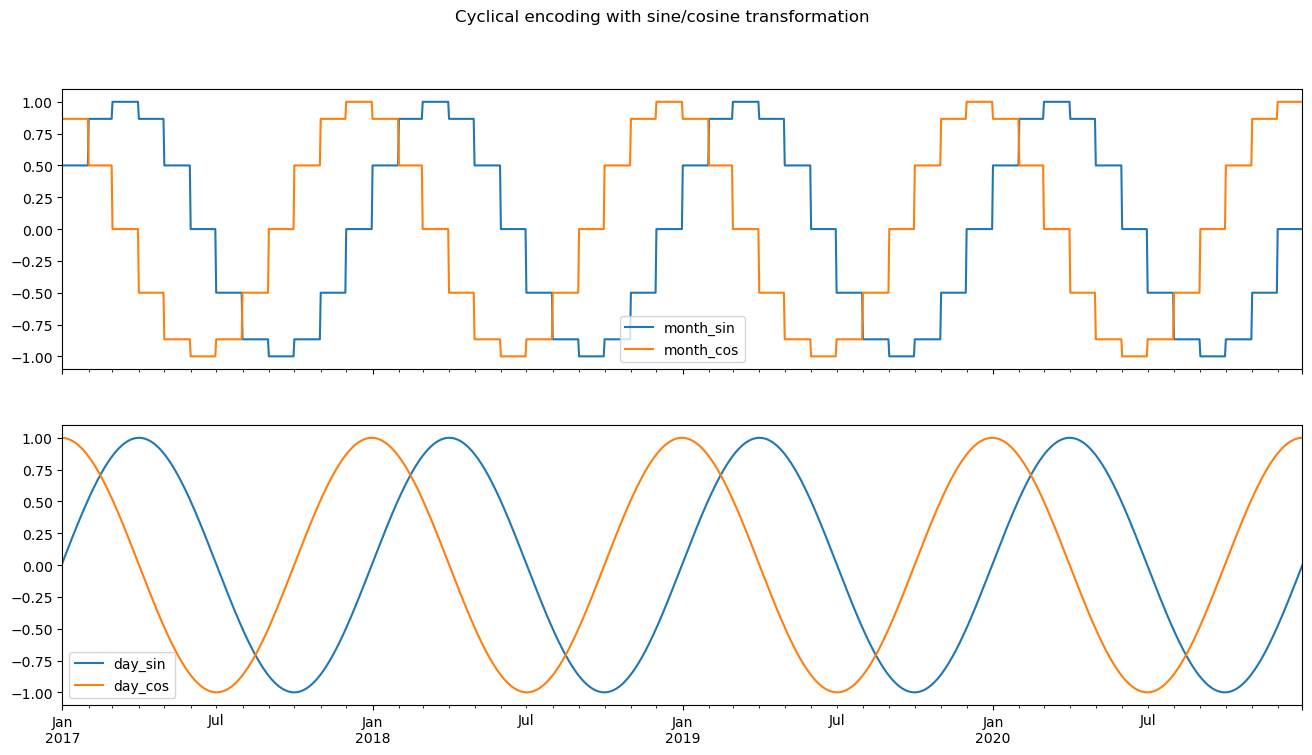

In [50]:
X_2 = X.copy()
X_2['month'] = X_2.index.month

X_2['month_sin'] = sin_transformer(12).fit_transform(X_2)['month']
X_2['month_cos'] = cos_transformer(12).fit_transform(X_2)['month']

X_2['day_sin'] = sin_transformer(365).fit_transform(X_2)['day_of_year']
X_2['day_cos'] = cos_transformer(365).fit_transform(X_2)['day_of_year']

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 8))
X_2[['month_sin', 'month_cos']].plot(ax=ax[0])
X_2[['day_sin', 'day_cos']].plot(ax=ax[1])
plt.suptitle('Cyclical encoding with sine/cosine transformation')

In [56]:
X_2.head()

,day_nr,day_of_year,month,month_sin,month_cos,day_sin,day_cos
2017-01-01,0,1,1,0.5,0.866025,0.017213,0.999852
2017-01-02,1,2,1,0.5,0.866025,0.034422,0.999407
2017-01-03,2,3,1,0.5,0.866025,0.051620,0.998667
2017-01-04,3,4,1,0.5,0.866025,0.068802,0.997630
2017-01-05,4,5,1,0.5,0.866025,0.085965,0.996298


In [57]:
y.head()

2017-01-01    4.273237
2017-01-02    3.900877
2017-01-03    4.735163
2017-01-04    5.644148
2017-01-05    4.314070
Freq: D, Name: day_nr, dtype: float64

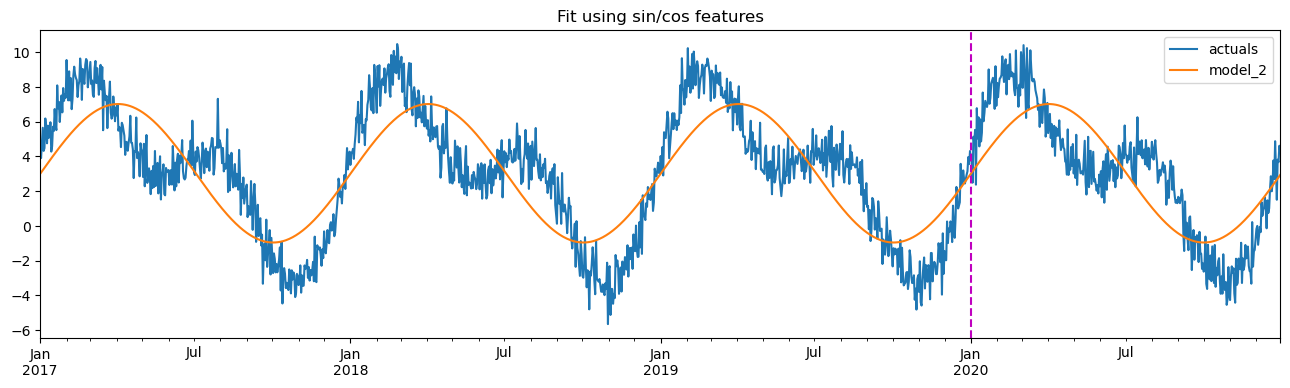

In [55]:
X_2_daily = X_2[['day_sin', 'day_cos']]

model_2 = LinearRegression().fit(X_2_daily.iloc[:TRAIN_END], y.iloc[:TRAIN_END])

results_df['model_2'] = model_2.predict(X_2_daily)
results_df[['actuals', 'model_2']].plot(figsize=(16, 4), title='Fit using sin/cos features')
plt.axvline(date(2020, 1, 1), c='m', linestyle='--')

In [67]:
X_2_daily_monthly = X_2[['month_sin', 'month_cos' ,'day_sin', 'day_cos', ]]
X_1_2 = pd.merge(X_1, X_2_daily_monthly, left_index=True, right_index=True)
X_1_2.head()

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,month_sin,month_cos,day_sin,day_cos
2017-01-01,0,0,0,0,0,0,0,0,0,0,0,0.5,0.866025,0.017213,0.999852
2017-01-02,0,0,0,0,0,0,0,0,0,0,0,0.5,0.866025,0.034422,0.999407
2017-01-03,0,0,0,0,0,0,0,0,0,0,0,0.5,0.866025,0.051620,0.998667
2017-01-04,0,0,0,0,0,0,0,0,0,0,0,0.5,0.866025,0.068802,0.997630
2017-01-05,0,0,0,0,0,0,0,0,0,0,0,0.5,0.866025,0.085965,0.996298


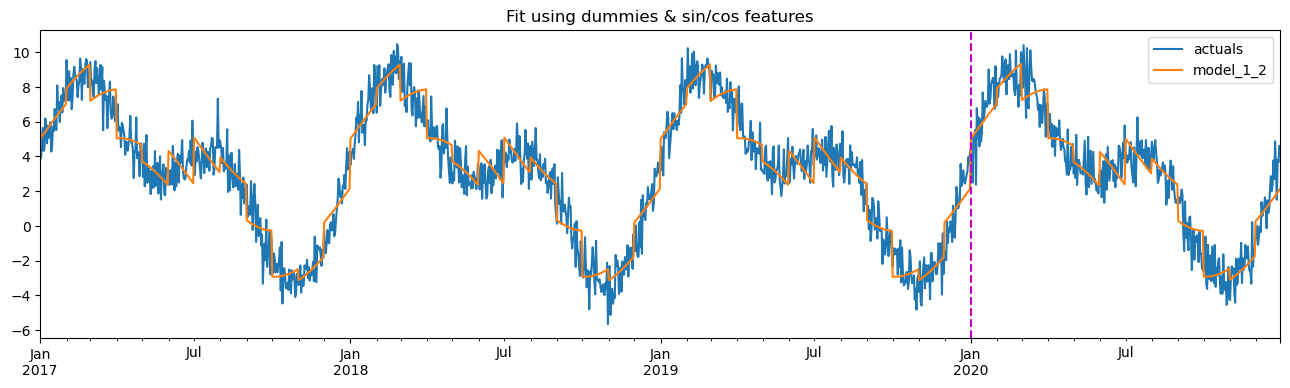

In [68]:
model_1_2 = LinearRegression().fit(X_1_2.iloc[:TRAIN_END], y.iloc[:TRAIN_END])
results_df['model_1_2'] = model_1_2.predict(X_1_2)
results_df[['actuals', 'model_1_2']].plot(figsize=(16, 4), title='Fit using dummies & sin/cos features')
plt.axvline(date(2020, 1, 1), c='m', linestyle='--')

## アプローチ3 : 放射状基底関数

In [69]:
X.head()

,day_nr,day_of_year
2017-01-01,0,1
2017-01-02,1,2
2017-01-03,2,3
2017-01-04,3,4
2017-01-05,4,5


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

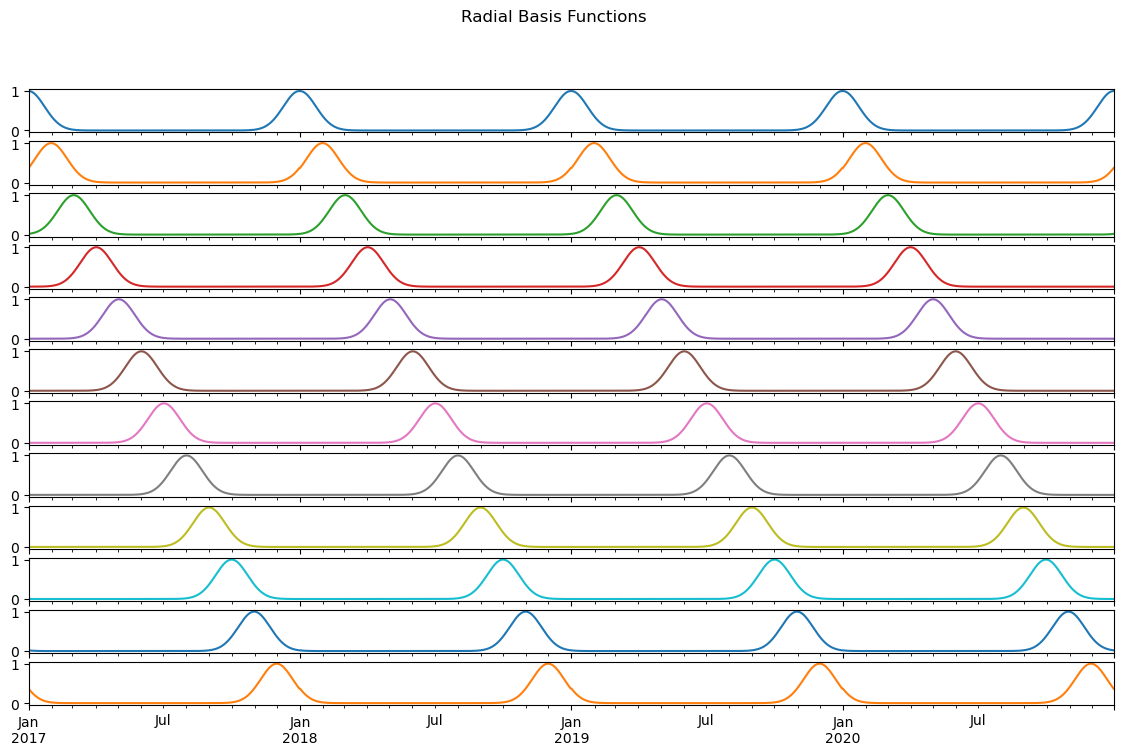

In [70]:
rbf = RepeatingBasisFunction(n_periods=12, column='day_of_year', input_range=(1, 365), remainder='drop')

rbf.fit(X)
X_3 = pd.DataFrame(index=X.index, data=rbf.transform(X))
X_3.plot(subplots=True, figsize=(14, 8), sharex=True, title='Radial Basis Functions', legend=False)

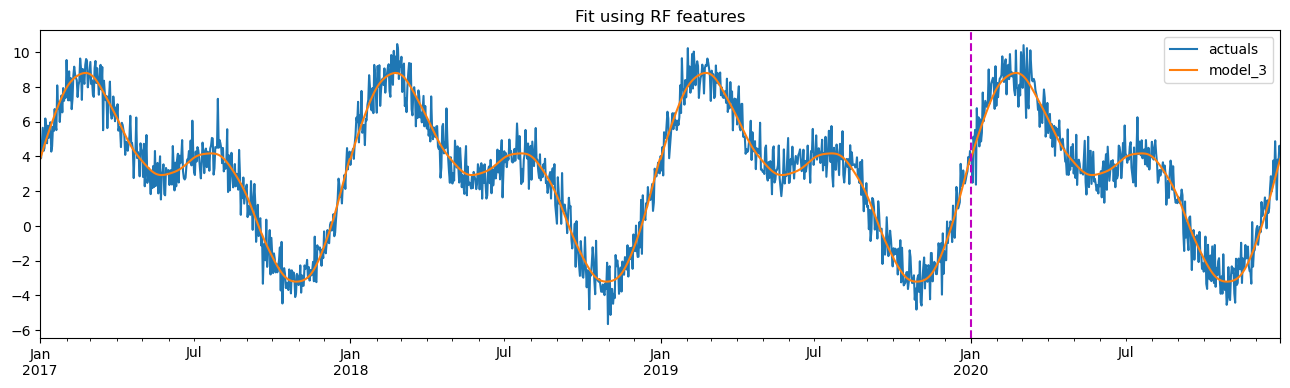

In [71]:
model_3 = LinearRegression().fit(X_3.iloc[:TRAIN_END], y.iloc[:TRAIN_END])
results_df['model_3'] = model_3.predict(X_3)
results_df[['actuals', 'model_3']].plot(figsize=(16, 4), title='Fit using RF features')
plt.axvline(date(2020, 1, 1), c='m', linestyle='--')

In [75]:
results_df = results_df.drop(['model_lgbm'], axis=1)

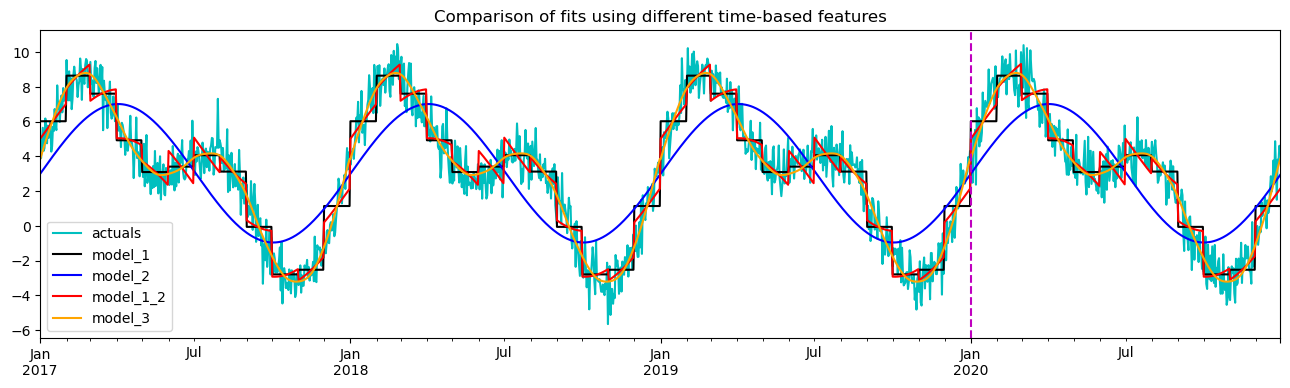

In [76]:
results_df.plot(title="Comparison of fits using different time-based features",
            	figsize=(16,4),
            	color = ["c", "k", "b", "r", 'orange'])
plt.axvline(date(2020, 1, 1), c="m", linestyle="--")

/home/takafumi/anaconda3/envs/PS_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/takafumi/anaconda3/envs/PS_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


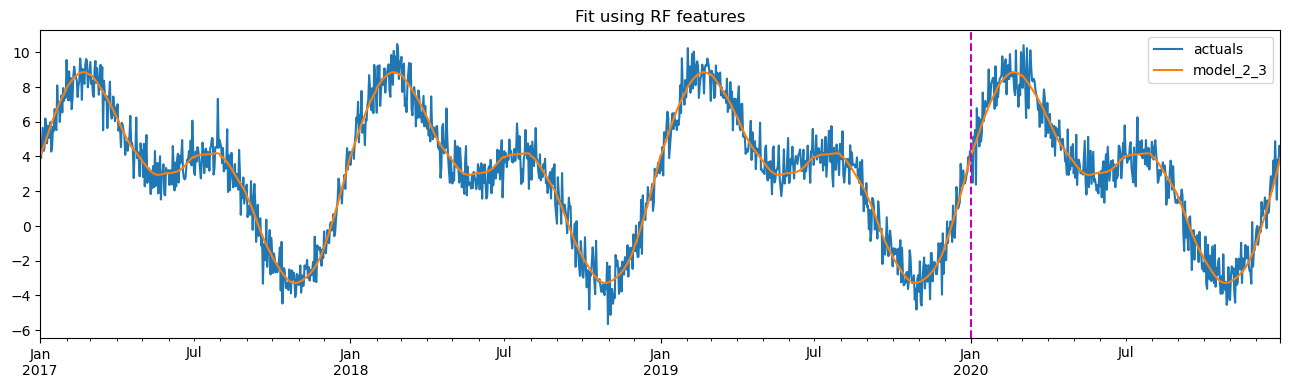

In [84]:
# 2+3
X_2_3 = pd.merge(X_2[['month_sin', 'month_cos', 'day_sin', 'day_cos']], X_3, left_index=True, right_index=True)
model_2_3 = LinearRegression().fit(X_2_3.iloc[:TRAIN_END], y.iloc[:TRAIN_END])

results_df['model_2_3'] = model_2_3.predict(X_2_3)

results_df[['actuals', 'model_2_3']].plot(figsize=(16, 4), title='Fit using RF features')
plt.axvline(date(2020, 1, 1), c='m', linestyle='--')

/home/takafumi/anaconda3/envs/PS_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/takafumi/anaconda3/envs/PS_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


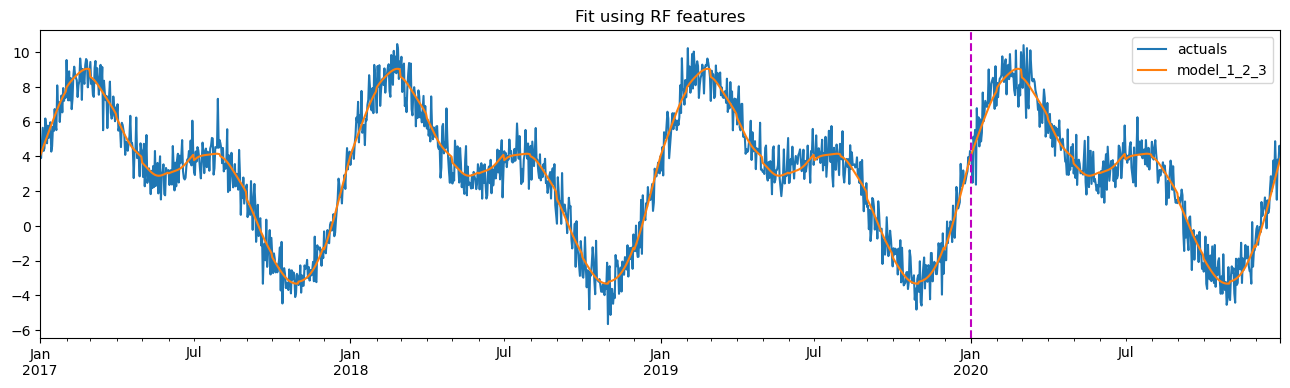

In [86]:
# 1+2+3
X_1_2_3 = pd.merge(X_1_2, X_3, left_index=True, right_index=True)
model_1_2_3 = LinearRegression().fit(X_1_2_3.iloc[:TRAIN_END], y.iloc[:TRAIN_END])

results_df['model_1_2_3'] = model_1_2_3.predict(X_1_2_3)

results_df[['actuals', 'model_1_2_3']].plot(figsize=(16, 4), title='Fit using RF features')
plt.axvline(date(2020, 1, 1), c='m', linestyle='--')

In [88]:
score_list = []
for fit_col in ["model_1", "model_2", 'model_1_2', "model_3", 'model_2_3', 'model_1_2_3']:
	scores = {
    	"model": fit_col,
    	"train_score": mean_absolute_error(
        	results_df.iloc[:TRAIN_END]["actuals"],
        	results_df.iloc[:TRAIN_END][fit_col]
    	),
    	"test_score": mean_absolute_error(
        	results_df.iloc[TRAIN_END:]["actuals"],
        	results_df.iloc[TRAIN_END:][fit_col]
    	)
	}
	score_list.append(scores)

scores_df = pd.DataFrame(score_list)
scores_df

,model,train_score,test_score
0,model_1,0.876548,0.925758
1,model_2,1.976644,1.990182
2,model_1_2,0.829042,0.881431
3,model_3,0.657744,0.692134
4,model_2_3,0.655923,0.696032
5,model_1_2_3,0.652632,0.707432
